<a href="https://colab.research.google.com/github/AraiKensuke/FitSpectrum/blob/master/FitPowerSpec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
#!pip install nitime              #  
#!pip install arviz==0.5.1        # pymc3 on Colab is v3.7.  We need old version of arviz

import sys
import importlib
#import buildsignal as bs

if importlib.util.find_spec("FitSpectrum") is None:
  %cd /content
  !git clone https://github.com/AraiKensuke/FitSpectrum.git

import pymc3 as pm
import numpy as _N
import matplotlib.pyplot as plt; plt.ion()

####  fit to PYMC3 model using posterior sampling.
####  model assumes up to 3 bumps in power spectrum
def do_fit_psd(f_at_obs, log_psd):
  # # define the model/function to be fitted.

  with pm.Model() as model3:
    #  SPECIFY prior distributions for parameters
    #amp = pm.Uniform('amp', 0.05, 0.4, testval= 0.15)
    amp1 = pm.HalfNormal('amp1', sigma=1)
    amp2 = pm.HalfNormal('amp2', sigma=1)
    amp3 = pm.HalfNormal('amp3', sigma=1)
    #size = pm.Uniform('size', 0.1, 2.5, testval= 1.0)
    width1 = pm.HalfNormal('width1', sigma=2)
    width2 = pm.HalfNormal('width2', sigma=2)
    width3= pm.HalfNormal('width3', sigma=2)
    mu1 = pm.Normal('mu1', mu=1, sigma=5)   #  initialize w/ diff values
    mu2 = pm.Normal('mu2', mu=15, sigma=5)
    mu3 = pm.Normal('mu3', mu=30, sigma=5)
    a = pm.Normal('a', 0.13, 40)
    b = pm.Normal('b', 0.13, 40)

    error = pm.HalfNormal("error", sigma=0.3)
    ####  Gaussian noise assumed on top of a/(f+b) shape
    gauss=pm.Deterministic('gauss',amp1*_N.exp(-0.5*(f_at_obs-mu1)**2/(width1**2))+amp2*_N.exp(-0.5*(f_at_obs-mu2)**2/(width2**2))+amp3*_N.exp(-0.5*(f_at_obs-mu3)**2/(width3**2))+a/(f_at_obs+b))

    y =pm.Normal('y', mu=gauss, sigma=error, observed=log_psd)

    #map_estimate=pm.find_MAP()    #  can also do point MAP estimate 
    step=pm.NUTS()
    trace=pm.sample(2000)

  return trace


Routines to create an oscillating signal with some spectral width, ie a signal whose instantaneous period fluctuates.

First, let's see what short time MT powerspec of a very tight oscillation looks like:

---



MT powerspec for a tight oscillation

(1.0, 55.0)

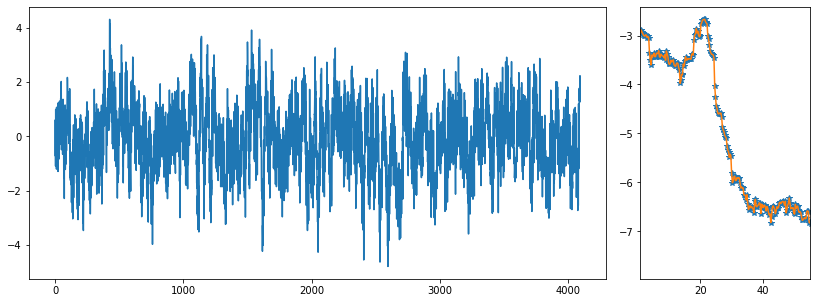

In [ ]:
np.random.seed(1000)   #  set the random seed.

###  Specify the signal 
f1=21.   # hz
coh1=0.982   # how coherent or sinusoidal is f1 osc?  0~1    1 near sinusoidal, > 0.95 neural-like

obs_nz    = 0.8   #  make this bigger to add more observation noise
comps         = [[[f1, coh1]], [0.96]]      #  describe AR(p) in terms of AR(2) and AR(1) components.
N             = 4096
dt            = 0.001
#  
signal         = bs.build_signal(N, dt, [comps], [1])  
signal         += obs_nz*np.random.randn(N)    #  add observation noise (white noise)


fig = plt.figure(figsize=(14, 5))
plt.subplot2grid((1, 4), (0, 0), colspan=3)
plt.plot(signal)
plt.subplot2grid((1, 4), (0, 3), colspan=1)
# multi-taper: for now, let's work on the average of tapers
# focus on 1 to 30 Hz
bw = 9
f, psd_mt, nu = tsa.multi_taper_psd(signal,Fs=1/dt, NW=bw , low_bias=False, adaptive=False, jackknife=False)
plt.plot(f,np.log(psd_mt),'*')
plt.plot(f,np.log(psd_mt))
plt.xlim(1,55)

In [ ]:

# # extract and plot results
# y_min = _N.percentile(trace.gauss,2.5,axis=0)
# y_max = _N.percentile(trace.gauss,97.5,axis=0)
# y_fit = _N.percentile(trace.gauss,50,axis=0)
# plt.plot(x,f_true,'b', marker='None', ls='-', lw=1, label='True')
# plt.errorbar(x,f,yerr=f_error, color='r', marker='.', ls='None', label='Observed')
# plt.plot(x,y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
# plt.fill_between(x, y_min, y_max, color='0.5', alpha=0.5)
# plt.legend()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [error, b, a, mu3, mu2, mu1, width3, width2, width1, amp3, amp2, amp1]
100%|██████████| 2500/2500 [03:12<00:00, 13.02it/s]
The acceptance probability does not match the target. It is 0.9839376162112976, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9602145273942566, but should be close to 0.8. Try to increase the number of tuning steps.


Now perform fit on PSD

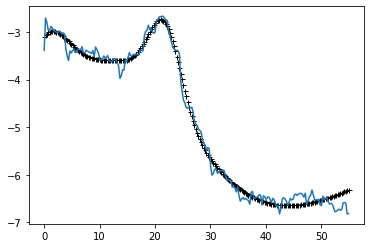

In [ ]:
theseInds = _N.where(f < 55)[0]
f_psd     = f[theseInds]

trace = do_fit_psd(f_psd, _N.log(psd_mt[theseInds]))
y_fit = _N.percentile(trace.gauss,50,axis=0)
plt.plot(f_psd, y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.plot(f_psd, np.log(psd_mt[theseInds]))

**Look at Gibbs samples and marginal posterior distributions of parameters**


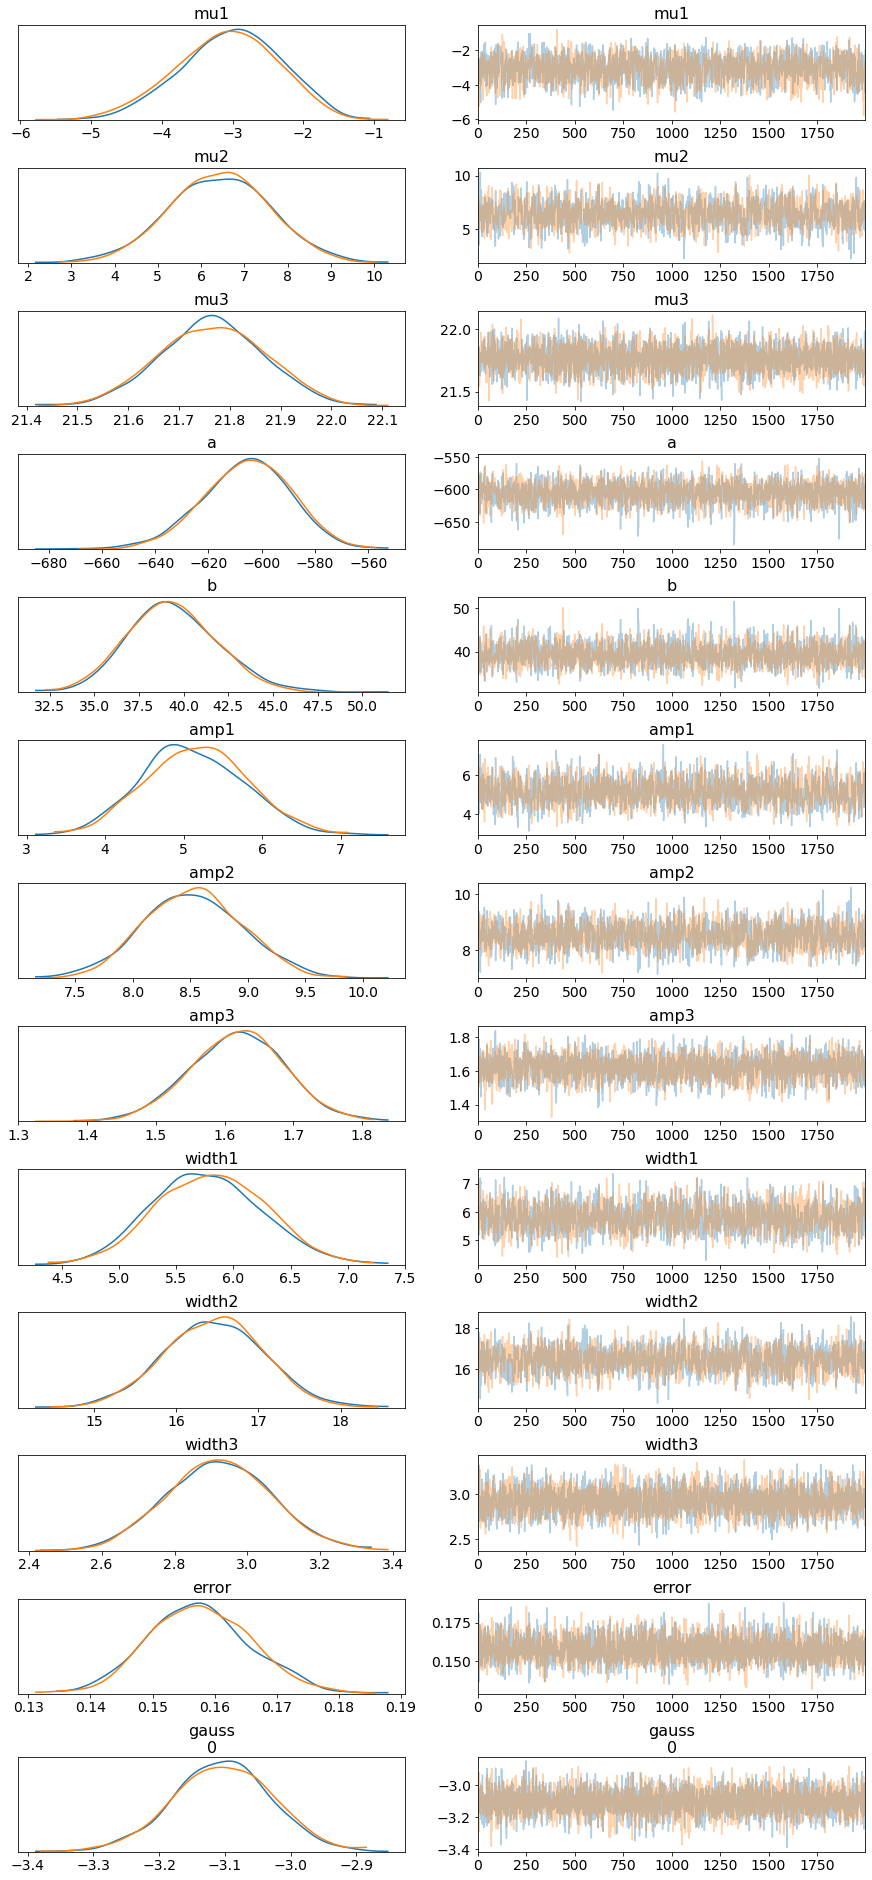

In [ ]:
trace = do_fit_psd(f_at_obs, log_psd)

import arviz as az
with model3:
    az.plot_trace(trace);

**Now let's load some actual EEG data recorded while a subject closed for about 15 seconds, and then openned their eyes for about 15 seconds.**
There is a clear qualitative difference in the way the EEG looks.

In [ ]:
eeg = _N.loadtxt("FitSpectrum/jan142021_01_00_00_smpl_v1.dat")

#  eeg has 5 channels of eeg data, 30 seconds in duration sampled at 300Hz.  shape is 9000 x 5

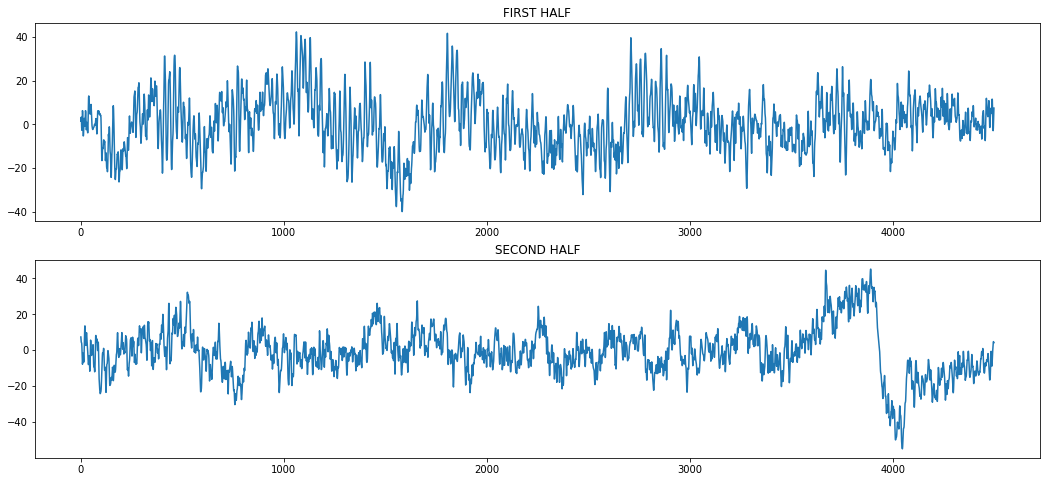

In [35]:
eeg_channel = 0
fig = plt.figure(figsize=(18, 8))
fig.add_subplot(2, 1, 1)
plt.title("FIRST HALF")
plt.plot(eeg[0:4500, eeg_channel])
fig.add_subplot(2, 1, 2)
plt.title("SECOND HALF")
plt.plot(eeg[4500:, eeg_channel])

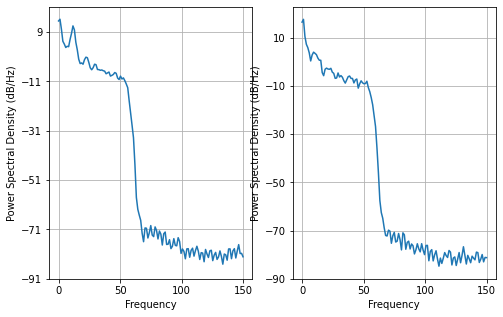

In [38]:
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(1, 2, 1)
eeg_psd1, eeg_f_psd1 = plt.psd(eeg[0:4500, eeg_channel], Fs=300)
fig.add_subplot(1, 2, 2)
eeg_psd2, eeg_f_psd2 = plt.psd(eeg[4500:, eeg_channel], Fs=300)

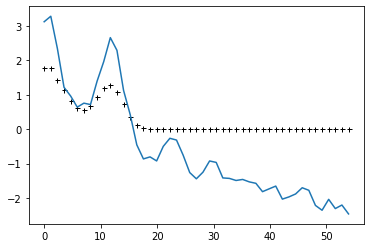

In [51]:
theseInds = _N.where(eeg_f_psd1 < 55)[0]

#trace = do_fit_psd(eeg_f_psd1[theseInds], _N.log(eeg_psd1[theseInds]))
y_fit = _N.percentile(trace.gauss,50,axis=0)
plt.plot(eeg_f_psd1[theseInds], y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.plot(eeg_f_psd1[theseInds], _N.log(eeg_psd1[theseInds]))

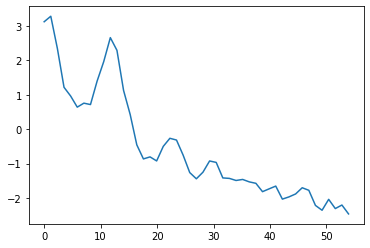

In [40]:
plt.plot(eeg_f_psd1[theseInds], _N.log(eeg_psd1[theseInds]))